# Notes on strain rate and velocity calculation


In [67]:
%load_ext autoreload
%autoreload 2 
import hvplot.xarray

import sys
sys.path.append("../../../xapres/")
import xapres as xa
import matplotlib.pyplot as plt
import xarray as xr
from datatree import DataTree
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
def load_zarr(f):
    return xr.open_dataset(f, engine = 'zarr', chunks = {})
LTG = load_zarr('/Users/jkingslake/Documents/science/ApRES/TG_apres/notebooks/zarrs/LTG_stacked.zarr').load()
dLTG = LTG.profile_stacked.displacement_timeseries().compute()
dLTG

<xarray.Dataset>
Dimensions:            (attenuator_setting_pair: 1, shot_number: 2, time: 350,
                        profile_range: 11889, bin_depth: 594)
Coordinates:
    AFGain             (attenuator_setting_pair) int64 -4
    attenuator         (attenuator_setting_pair) float64 22.0
    burst_number       (shot_number, time) int64 0 1 0 1 0 1 0 ... 0 1 0 1 0 1 0
    filename           (shot_number, time) <U90 'gs://ldeo-glaciology/apres/t...
    orientation        (time) <U7 'unknown' 'unknown' ... 'unknown' 'unknown'
  * profile_range      (profile_range) float64 0.0 0.2103 ... 2.5e+03 2.5e+03
    profile_time       (shot_number, time) datetime64[ns] 2023-01-16T00:52:00...
  * time               (time) datetime64[ns] 2023-01-16T12:51:57.500000 ... 2...
  * shot_number        (shot_number) int64 1 2
  * bin_depth          (bin_depth) float64 1.998 6.204 ... 2.492e+03 2.496e+03
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    profile_stacked    (shot_number, time, attenuator_setting_pair, profile_range) complex128 ...
    coherence          (time, attenuator_setting_pair, bin_depth) complex128 ...
    phase              (time, attenuator_setting_pair, bin_depth) float64 4.9...
    phase_uncertainty  (time, attenuator_setting_pair, bin_depth) float64 0.0...
    displacement       (time, attenuator_setting_pair, bin_depth) float64 2.2...
    disp_uncertainty   (time, attenuator_setting_pair, bin_depth) float64 7.9...
    velocity           (time, attenuator_setting_pair, bin_depth) float64 0.0...
    strain_rate        (time) float64 0.005968 0.005709 ... 0.007253 0.006713
    surface_intercept  (time) float64 -0.465 -0.5585 -0.4422 ... -0.3116 0.04894
    r_squared          (time) float64 0.8714 0.9794 0.945 ... 0.9818 0.7375
Attributes:
    bin_size:     20
    description:  Time series of profiles of coherence, phase, displacement, ...
    processing:   Created by the displacement_timeseries function in xapres u...
    offset:       1

## Compute the time deifference between shot and the preceeding shot

In [42]:
dt_years = ((dLTG.profile_time.sel(shot_number=2) - dLTG.profile_time.sel(shot_number=1)) / np.timedelta64(1,'D') / 365.25).rename('dt_years')
dt_years.attrs['units'] = 'years'
dt_years.attrs['long_name'] = 'Time between shots'
dt_years.attrs['description'] = 'Time in years between shots used in each measurement of displacement, vertical velocity, etc. dt_years[i] is the time between shot [j] and shot [j-1]'

## Calculate the velocity

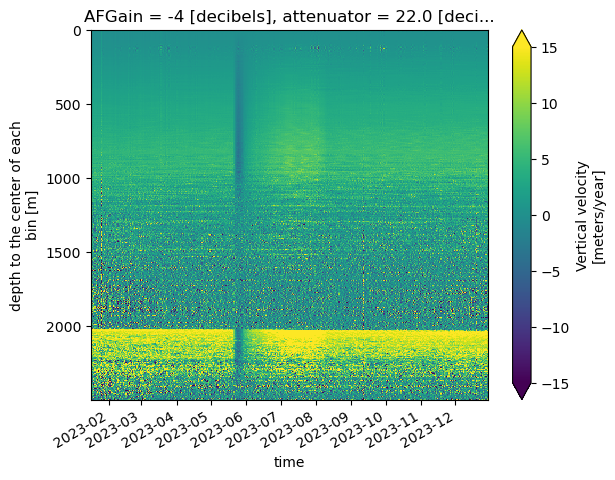

In [72]:
velocity = (dLTG.displacement / dt_years).rename('velocity')
velocity.attrs['units'] = 'meters/year'
velocity.attrs['long_name'] = 'Vertical velocity'
velocity.plot(x='time', yincrease = False, vmin=-15, vmax = 15)

## Use a linear fit to calculate the vertical strian rate

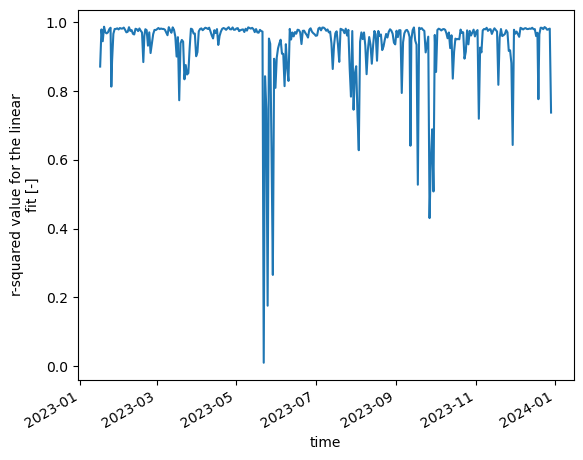

In [17]:
def addStrainRates(self, lower_limit_on_fit = 800):
    data_cropped = self.velocity\
            .squeeze()\
            .where(self.velocity.bin_depth < lower_limit_on_fit)
    
    fit_ds = data_cropped.polyfit('bin', 1, full = True)
            
    strain_rate = fit_ds.sel(degree = 1, drop =True).polyfit_coefficients.rename('strain_rate')
    surface_intercept =  fit_ds.sel(degree = 0, drop =True).polyfit_coefficients.rename('surface_intercept') 

    strain_rate.attrs['units'] = '1/year'
    strain_rate.attrs['long_name'] = f"vertical strain rate in upper {lower_limit_on_fit} m"
    surface_intercept.attrs['units'] = 'meters/year'
    surface_intercept.attrs['long_name'] = 'vertical velocity at the surface from the linear fit'
    
    y_mean = data_cropped.mean(dim = 'bin')
    SS_tot = ((data_cropped - y_mean)**2).sum(dim = 'bin')
    R2 = (1 - (fit_ds.polyfit_residuals/SS_tot)).rename('r_squared')
    R2.attrs['long_name'] = 'r-squared value for the linear fit'
    R2.attrs['units'] = '-'   
    
    return xr.merge([self, strain_rate, surface_intercept, R2])


xr.Dataset.addStrainRates = addStrainRates

dLTG_ezz = xr.merge([dLTG, velocity]).addStrainRates()
dLTG_ezz.r_squared.plot()

## Test implementation in xapres.utils

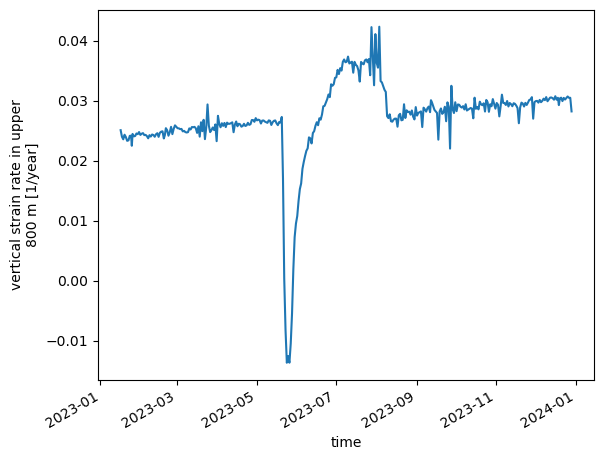

In [8]:
dLTG = LTG.profile_stacked.displacement_timeseries(lower_limit_on_fit=800)
dLTG.strain_rate.plot()

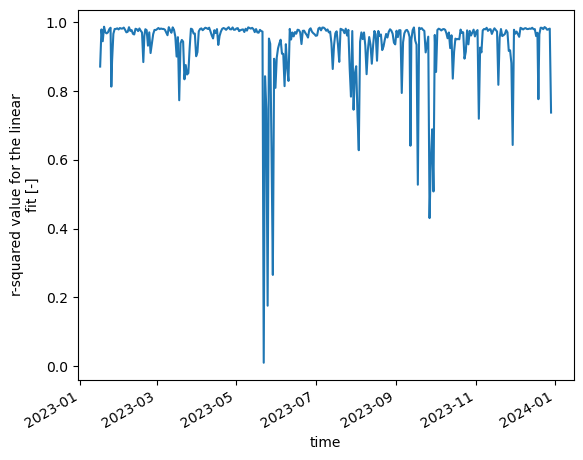

In [24]:
dLTG.r_squared.plot()

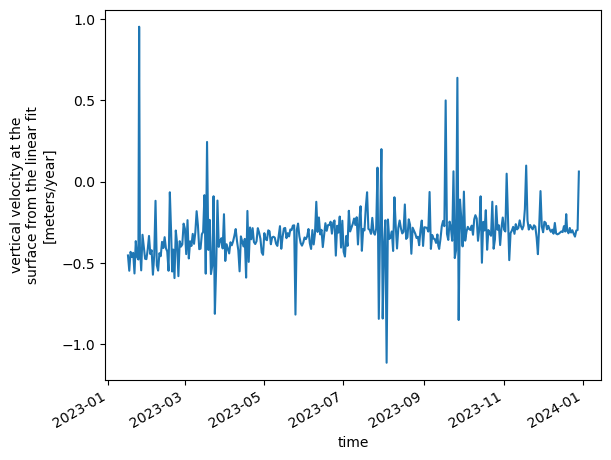

In [20]:
dLTG.surface_intercept.plot()

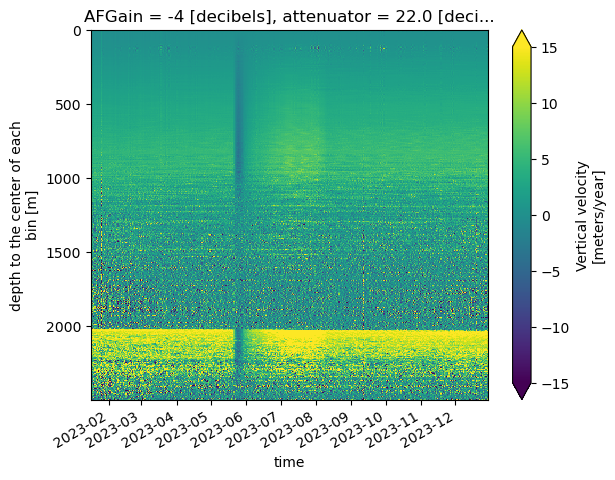

In [73]:
dLTG.velocity.plot(x='time', yincrease = False, vmin=-15, vmax = 15)

Check that it works as a method of dataarrays

In [7]:
dLTG.velocity.computeStrainRates()

<xarray.Dataset>
Dimensions:            (time: 350)
Coordinates:
  * time               (time) datetime64[ns] 2023-01-16T12:51:57.500000 ... 2...
    AFGain             int64 -4
    attenuator         float64 22.0
    orientation        (time) <U7 'unknown' 'unknown' ... 'unknown' 'unknown'
Data variables:
    strain_rate        (time) float64 0.0251 0.02401 0.02358 ... 0.03051 0.02823
    surface_intercept  (time) float64 -0.4531 -0.5471 -0.431 ... -0.2971 0.06235
    r_squared          (time) float64 0.8714 0.9794 0.945 ... 0.9818 0.7375
Attributes:
    units:                      1/year
    long_name:                  vertical strain rate in upper 800 m
    lower_limit_on_fit_meters:  800

Check that the offset is not effecting the results in an erroneous way. 


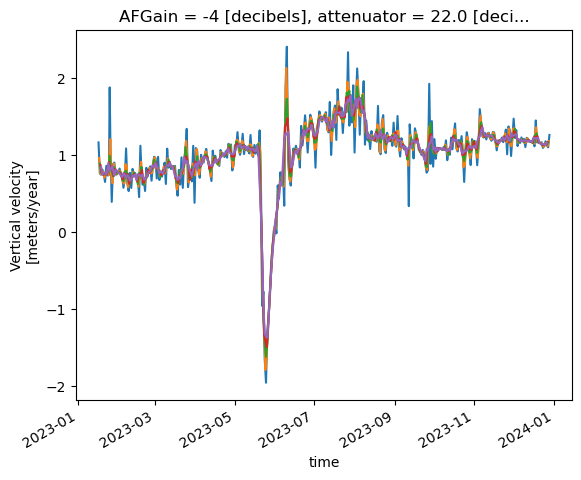

In [22]:
LTG.profile_stacked.displacement_timeseries(lower_limit_on_fit=800, offset = 1).velocity.isel(bin=50).plot()
LTG.profile_stacked.displacement_timeseries(lower_limit_on_fit=800, offset = 2).velocity.isel(bin=50).plot()
LTG.profile_stacked.displacement_timeseries(lower_limit_on_fit=800, offset = 3).velocity.isel(bin=50).plot()
LTG.profile_stacked.displacement_timeseries(lower_limit_on_fit=800, offset = 4).velocity.isel(bin=50).plot()
LTG.profile_stacked.displacement_timeseries(lower_limit_on_fit=800, offset = 5).velocity.isel(bin=50).plot()

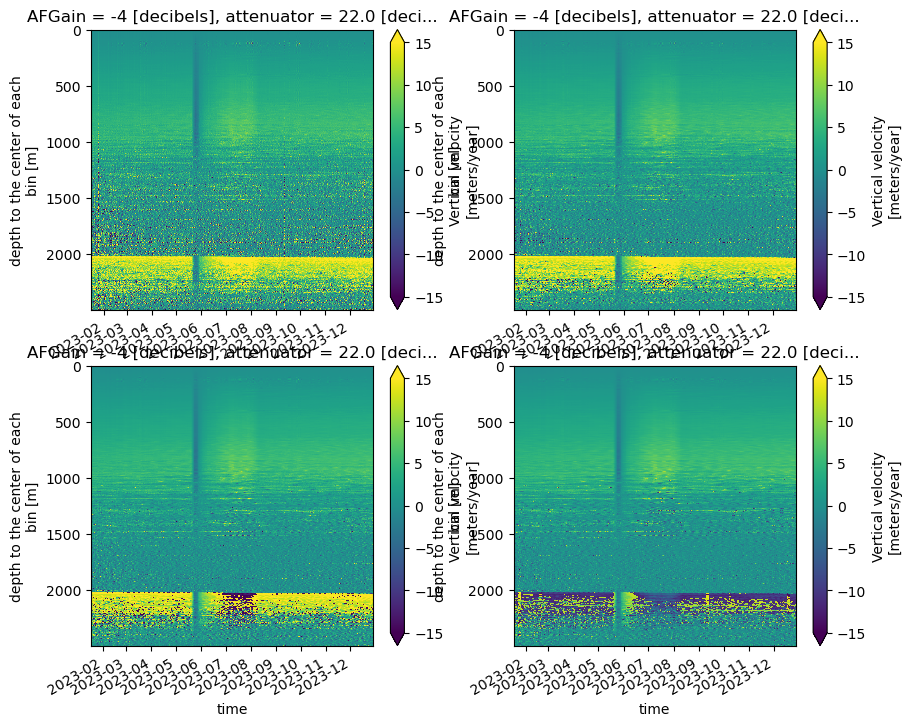

In [74]:
fig, ax = fig, axs = plt.subplots(2, 2, figsize=(10, 8))


LTG.profile_stacked.displacement_timeseries(lower_limit_on_fit=800, offset = 1).velocity.plot(ax = ax[0,0], x='time', yincrease = False, vmin=-15, vmax = 15)
LTG.profile_stacked.displacement_timeseries(lower_limit_on_fit=800, offset = 2).velocity.plot(ax = ax[0,1], x='time', yincrease = False, vmin=-15, vmax = 15)
LTG.profile_stacked.displacement_timeseries(lower_limit_on_fit=800, offset = 3).velocity.plot(ax = ax[1,0], x='time', yincrease = False, vmin=-15, vmax = 15)
LTG.profile_stacked.displacement_timeseries(lower_limit_on_fit=800, offset = 4).velocity.plot(ax = ax[1,1], x='time', yincrease = False, vmin=-15, vmax = 15)

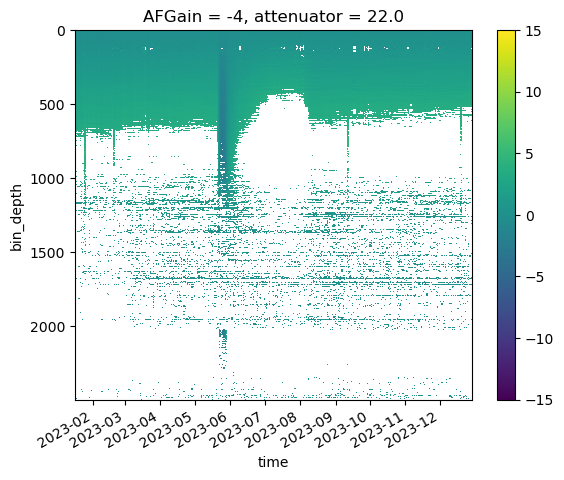

In [75]:
ds = LTG.profile_stacked.displacement_timeseries(lower_limit_on_fit=800, offset = 2)
xr.where(ds.coherence > 0.9, ds.velocity, np.nan).plot(x='time', yincrease = False, vmin=-15, vmax = 15)

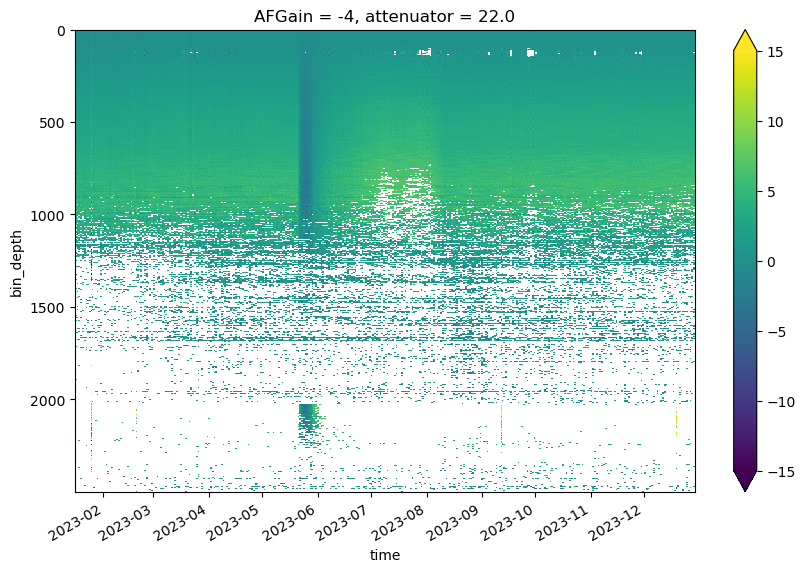

In [76]:
fig, ax = plt.subplots(figsize=(10, 6))

ds = LTG.profile_stacked.displacement_timeseries(lower_limit_on_fit=800, offset = 1)


In [77]:
!git clone https://gist.github.com/6d8c811c5b8fff50b75bd6c9bda616de.git

Cloning into '6d8c811c5b8fff50b75bd6c9bda616de'...
remote: Enumerating objects: 6, done.
remote: Total 6 (delta 0), reused 0 (delta 0), pack-reused 6 (from 1)
Receiving objects: 100% (6/6), done.
Resolving deltas: 100% (1/1), done.


In [78]:
!getgist jkingslake xarray_grid_search.py


  Fetching https://api.github.com/users/jkingslake/gists?page=1
  Fetching https://api.github.com/users/jkingslake/gists?page=2
  Reading https://gist.githubusercontent.com/jkingslake/6d8c811c5b8fff50b75bd6c9bda616de/raw/27b4ddb20c39e0d285200515776908d53002b7c5/xarray_grid_search.py
  Saving xarray_grid_search.py
  Done!


/Users/jkingslake/Documents/science/ApRES/xapres/notebooks/test_notes/xarray_grid_search.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
python(98858) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
#!pip install getgist
#!getgist jkingslake xarray_grid_search.py
import xarray_grid_search as xgs
xgs.gridSearch(LTG.profile_stacked.displacement_timeseries, lower_limit_on_fit=[800, 1000, 1200, 1400]).strain_rate.plot(hue='lower_limit_on_fit')



NameError: name 'LTG' is not defined

In [89]:

xgs.gridSearch(LTG.profile_stacked.displacement_timeseries, lower_limit_on_fit=[800, 1000, 1200, 1400])

  0%|          | 0/4 [00:00<?, ?it/s]

<xarray.Dataset>
Dimensions:             (lower_limit_on_fit: 4, attenuator_setting_pair: 1,
                         shot_number: 2, time: 350, profile_range: 11889,
                         bin_depth: 594)
Coordinates:
  * lower_limit_on_fit  (lower_limit_on_fit) int64 800 1000 1200 1400
    AFGain              (attenuator_setting_pair) int64 -4
    attenuator          (attenuator_setting_pair) float64 22.0
    burst_number        (shot_number, time) int64 0 1 0 1 0 1 0 ... 1 0 1 0 1 0
    filename            (shot_number, time) <U90 'gs://ldeo-glaciology/apres/...
    orientation         (time) <U7 'unknown' 'unknown' ... 'unknown' 'unknown'
  * profile_range       (profile_range) float64 0.0 0.2103 ... 2.5e+03 2.5e+03
    profile_time        (shot_number, time) datetime64[ns] 2023-01-16T00:52:0...
  * time                (time) datetime64[ns] 2023-01-16T12:51:57.500000 ... ...
  * shot_number         (shot_number) int64 1 2
  * bin_depth           (bin_depth) float64 1.998 6.204 ... 2.492e+03 2.496e+03
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    profile_stacked     (shot_number, time, attenuator_setting_pair, profile_range, lower_limit_on_fit) complex128 ...
    coherence           (time, attenuator_setting_pair, bin_depth, lower_limit_on_fit) complex128 ...
    phase               (time, attenuator_setting_pair, bin_depth, lower_limit_on_fit) float64 ...
    phase_uncertainty   (time, attenuator_setting_pair, bin_depth, lower_limit_on_fit) float64 ...
    displacement        (time, attenuator_setting_pair, bin_depth, lower_limit_on_fit) float64 ...
    disp_uncertainty    (time, attenuator_setting_pair, bin_depth, lower_limit_on_fit) float64 ...
    velocity            (time, attenuator_setting_pair, bin_depth, lower_limit_on_fit) float64 ...
    strain_rate         (time, lower_limit_on_fit) float64 0.005968 ... 0.001888
    surface_intercept   (time, lower_limit_on_fit) float64 -0.465 ... 1.939
    r_squared           (time, lower_limit_on_fit) float64 0.8714 ... 0.1008
Attributes:
    bin_size:     20
    description:  Time series of profiles of coherence, phase, displacement, ...
    processing:   Created by the displacement_timeseries function in xapres u...
    offset:       1